In [128]:
import numpy as np
import numba
import matplotlib.pyplot as plt
import astropy.table
import lsst.afw.table as afwTable

In [130]:
table = afwTable.SourceCatalog.readFits(
    "/epyc/data4/DEEP/data/sources/calexp_mask_sources_DECam_VR_VR_DECam_c0007_6300_0_2600_0_1028542_N19_DEEP_20210903_B0b_scienceHASHsourcesForMasks_20240513T011634Z.fits"
).asAstropy()


In [121]:
table = astropy.table.Table.read("../data/detection.csv")

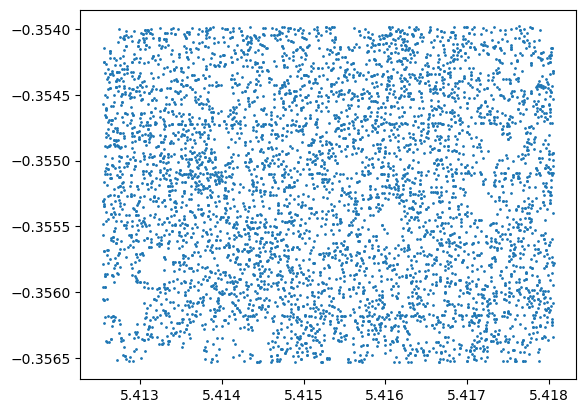

In [133]:
plt.scatter(table['coord_ra'], table['coord_dec'], c=table['time'], s=1)
plt.show()

In [123]:
@numba.njit()
def propogate(x: np.ndarray, b: np.ndarray, reference_time: np.float64):
    """
    Inputs:
        x (np.ndarray): 3 tuple of ra/dec/time
        b (np.ndarray): 2 tuple of v_ra / v_dec
        reference_time (np.float64): reference time to propogate to
    """
    vx = b[0]
    vy = b[1]
    x_prime = x[0] - vx * (x[2] - reference_time)
    y_prime = x[1] - vy * (x[2] - reference_time)
    return x_prime, y_prime


@numba.njit(parallel=True)
def propogate_array(X: np.ndarray, b: np.ndarray, reference_time: np.float64):
    """
    Inputs:
        X (np.ndarray): n x 3 array of ra/dec/time
        b (np.ndarray): m x 2 array of v_ra / v_dec
        reference_time (np.float64): reference time to propogate to
        
    Outputs:
        M (np.ndarray): m x n x 2 array of n propogated positions using m directions
    """
    num_b = b.shape[0]
    n = X.shape[0]
    M = np.zeros((num_b, n, 2))
    for i in numba.prange(num_b):
        for j in range(n):
            M[i, j] = propogate(X[j], b[i], reference_time)
    return M


@numba.njit()
def digitize_point(p, min_x, min_y, dx, dy):
    return int((p[0] - min_x)/dx), int((p[1] - min_y)/dy)


@numba.njit(parallel=True)
def vote_hough_X(X: np.ndarray, b: np.ndarray, x_min, y_min, dx, dy, reference_time, hough: np.ndarray, coef: np.float64=1):
    n, d = X.shape
    num_b = b.shape[0]
    for b_idx in numba.prange(num_b): # for each direction
        if b_idx < num_b:
            b_i = b[b_idx]
            for i in range(n): # for each point
                x_prime, y_prime = propogate(X[i], b_i, reference_time)
                x_idx, y_idx = digitize_point(np.array([x_prime, y_prime]), x_min, y_min, dx, dy)
                if x_idx < hough.shape[1] and y_idx < hough.shape[2]:
                    hough[b_idx, x_idx, y_idx] += coef


In [124]:
v = 0.24304251188290005
phi = -2.673392590944811
v_ra = v * np.cos(phi)
v_dec = v * np.sin(phi)
print(v_ra, v_dec)
b = np.array([[v_ra, v_dec]])
print(b.shape)
X = np.array([table[c].data for c in ['coord_ra', 'coord_dec', 'time']]).T
X[:, 0] *= 180/np.pi
X[:, 1] *= 180/np.pi
reference_time = X[:, 2].min()
print(reference_time)

dx = 1/3600
min_x, max_x = X[:, 0].min(), X[:, 0].max()
min_y, max_y = X[:, 1].min(), X[:, 1].max()
num_x = int((max_x - min_x)/dx + 1)
num_y = int((max_y - min_y)/dx + 1)

hough = np.zeros((b.shape[0], num_x, num_y), dtype=np.int32)

M = propogate_array(X, b, X[:, 2].min())
vote_hough_X(X, b, min_x, min_y, dx, dx, reference_time, hough)

# plt.scatter(M[0, :, 0], M[0, :, 1], s=1, c=X[:, 2])
# plt.show()

-0.21688676538084753 -0.10968041568567657
(1, 2)
2459467.583012657


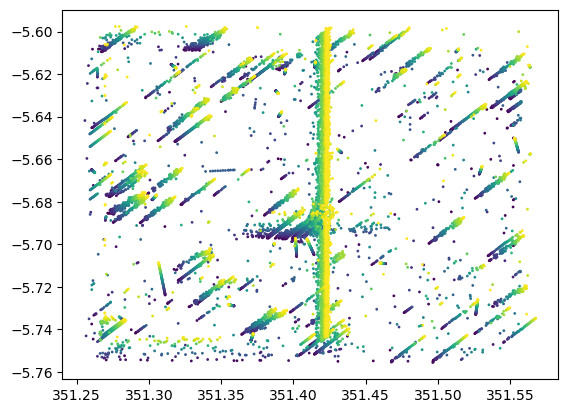

In [125]:
plt.scatter(M[0, :, 0], M[0, :, 1], c=X[:, 2], s=1)
plt.show()

In [126]:
min_x, max_x, num_x, min_y, max_y, num_y

(351.2457233378363,
 351.5522672894772,
 1104,
 -5.756512783840467,
 -5.608290629144075,
 534)

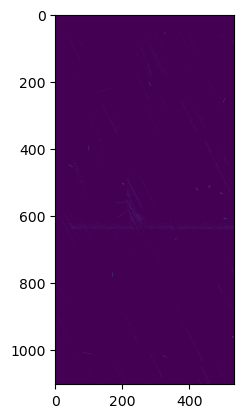

In [127]:
plt.imshow(hough[0])
plt.show()

In [116]:
hough[0][np.where(hough[0] == hough[0].max())]

array([21], dtype=int32)

In [120]:
np.where(hough[0] == 21)

(array([934]), array([47]))